## Fingerprinting

In [7]:
import os
import pandas as pd
import numpy as np

In [2]:
root = os.getcwd()
data = root + '\\DataSet3.xlsx'
data_xlsx = pd.read_excel(data)

In [3]:
data_xlsx

,Unnamed: 0,SMILES string,Homo-lumo band gap,Enthalpy,Specific Heat
0,0,C,0.5048,-40.475117,6.469
1,1,N,0.3399,-56.522082,6.316
2,2,O,0.3615,-76.400922,6.002
3,3,C#C,0.3351,-77.304583,8.574
4,4,C#N,0.3796,-93.408425,6.278
...,...,...,...,...,...
50366,50366,O=CC1CC2OCC=C12,0.2068,-421.791350,28.927
50367,50367,O=CC1NC2CCC=C12,0.2027,-401.911702,29.799
50368,50368,O=CC1OC2CCC=C12,0.2089,-421.789162,29.013
50369,50369,O=CN1CC2CCC=C12,0.2074,-401.942149,29.365


In [124]:
import rdkit
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import MolFromSmiles

mol_desc = []

for smiles in data_xlsx['SMILES string']:
    mol = MolFromSmiles(smiles)
    desc = GetMorganFingerprintAsBitVect(mol, radius = 3, nBits = 1024)
    mol_desc.append(np.asarray(desc))

In [125]:
mol_desc = np.array(mol_desc)
df_target = data_xlsx.iloc[:,2:]

## Model Building

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

In [126]:
y = np.array(df_target).reshape((50371,3))

In [189]:
X_train, X_test, y_train, y_test = train_test_split(mol_desc, y, test_size=0.2)

In [143]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [144]:
y_train

array([[ 2.78600000e-01, -3.78710711e+02,  3.02970000e+01],
       [ 2.76700000e-01, -3.19565445e+02,  2.51460000e+01],
       [ 2.01700000e-01, -4.16791803e+02,  3.10440000e+01],
       ...,
       [ 2.26100000e-01, -3.82039577e+02,  2.80080000e+01],
       [ 2.03400000e-01, -3.62582448e+02,  2.44280000e+01],
       [ 1.95500000e-01, -4.36597214e+02,  2.66060000e+01]])

## HOMO LUMO Bond

In [111]:
from keras import regularizers

In [168]:
n_cols = X_train.shape[1]

model = Sequential()
enc_1 = Dense(100, activation='relu', input_shape = (n_cols,))
model.add(enc_1)
model.add(Dropout(0.2))
enc_2 = Dense(50, activation='relu',kernel_regularizer = regularizers.l2(0.01))
model.add(enc_2)
enc_3 = Dense(1, activation='relu')
model.add(enc_3)

lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error')

dnn = model.fit(X_train, y_train[:,0], epochs=20, verbose=1, validation_split=0.01)

Epoch 1/20
1247/1247 [==============================] - 5s 3ms/step - loss: 0.0347 - val_loss: 7.1005e-04
Epoch 2/20
1247/1247 [==============================] - 4s 3ms/step - loss: 6.0848e-04 - val_loss: 5.6729e-04
Epoch 3/20
1247/1247 [==============================] - 4s 3ms/step - loss: 5.2268e-04 - val_loss: 5.3755e-04
Epoch 4/20
1247/1247 [==============================] - 4s 3ms/step - loss: 4.7454e-04 - val_loss: 4.6014e-04
Epoch 5/20
1247/1247 [==============================] - 4s 3ms/step - loss: 4.2925e-04 - val_loss: 5.1647e-04
Epoch 6/20
1247/1247 [==============================] - 4s 3ms/step - loss: 3.8729e-04 - val_loss: 4.2226e-04
Epoch 7/20
1247/1247 [==============================] - 4s 3ms/step - loss: 3.5712e-04 - val_loss: 4.4782e-04
Epoch 8/20
1247/1247 [==============================] - 4s 3ms/step - loss: 3.2966e-04 - val_loss: 3.9802e-04
Epoch 9/20
1247/1247 [==============================] - 4s 3ms/step - loss: 3.0247e-04 - val_loss: 4.2105e-04
Epoch 10/20
12

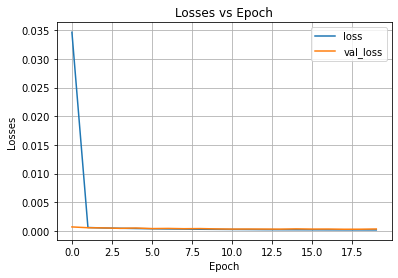

In [169]:
plt.plot(dnn.history['loss'], label='loss')
plt.plot(dnn.history['val_loss'], label='val_loss')
plt.title("Losses vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.grid()
plt.legend()
plt.show()

In [170]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

1260/1260 [==============================] - 2s 2ms/step


In [171]:
from sklearn.metrics import r2_score
print(r2_score(y_pred_train, y_train[:,0]))
print(r2_score(y_pred_test,y_test[:,0]))

0.9431987524046798
0.8583064186129798


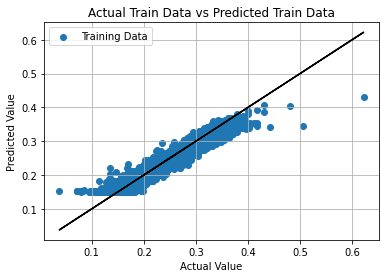

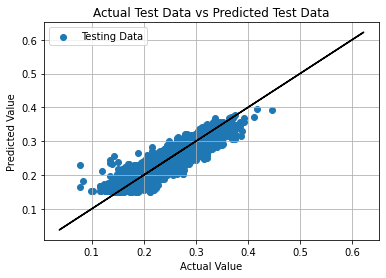

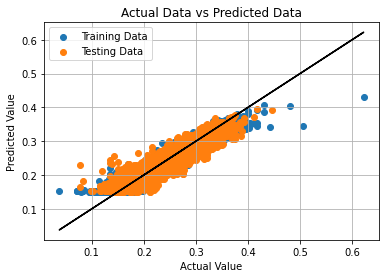

In [172]:
ytrain = y_train[:,0]
ytest = y_test[:,0]

plt.scatter(ytrain, y_pred_train,label='Training Data')
plt.title("Actual Train Data vs Predicted Train Data")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.plot(ytrain, ytrain, 'k-')
plt.grid()
plt.show()

plt.scatter(ytest, y_pred_test, label='Testing Data')
plt.title("Actual Test Data vs Predicted Test Data")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.plot(ytrain, ytrain, 'k-')
plt.grid()
plt.show()

plt.scatter(ytrain, y_pred_train,label='Training Data')
plt.scatter(ytest, y_pred_test, label='Testing Data')
plt.title("Actual Data vs Predicted Data")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.plot(ytrain, ytrain, 'k-')
plt.grid()
plt.show()

## Enthalpy

In [199]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(1024,)))
model.add(Dropout(0.1))
model.add(Dense(30, activation ='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
mod = model.fit(X_train, y_train[:,1], epochs=30, verbose=1, validation_split=0.1)

Epoch 1/30
1134/1134 [==============================] - 7s 5ms/step - loss: 18914.7246 - val_loss: 1630.8882
Epoch 2/30
1134/1134 [==============================] - 6s 5ms/step - loss: 1757.8137 - val_loss: 1203.8480
Epoch 3/30
1134/1134 [==============================] - 6s 5ms/step - loss: 1352.6475 - val_loss: 847.7388
Epoch 4/30
1134/1134 [==============================] - 6s 5ms/step - loss: 1104.2236 - val_loss: 646.7961
Epoch 5/30
1134/1134 [==============================] - 6s 5ms/step - loss: 960.5137 - val_loss: 570.7238
Epoch 6/30
1134/1134 [==============================] - 5s 4ms/step - loss: 923.2997 - val_loss: 561.5912
Epoch 7/30
1134/1134 [==============================] - 5s 4ms/step - loss: 904.9543 - val_loss: 551.2184
Epoch 8/30
1134/1134 [==============================] - 5s 5ms/step - loss: 875.1893 - val_loss: 537.2945
Epoch 9/30
1134/1134 [==============================] - 6s 5ms/step - loss: 843.8965 - val_loss: 535.0112
Epoch 10/30
1134/1134 [================

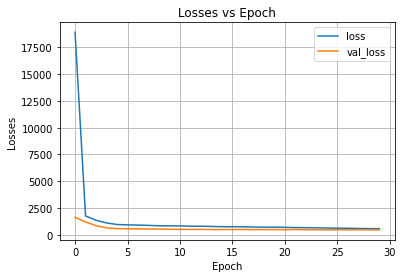

In [201]:
plt.plot(mod.history['loss'], label='loss')
plt.plot(mod.history['val_loss'], label='val_loss')
plt.title("Losses vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.grid()
plt.legend()
plt.show()

In [202]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

1260/1260 [==============================] - 4s 3ms/step


In [203]:
from sklearn.metrics import r2_score
print(r2_score(y_pred_train, y_train[:,1]))
print(r2_score(y_pred_test,y_test[:,1]))

0.8105393108787556
0.7154025793114425


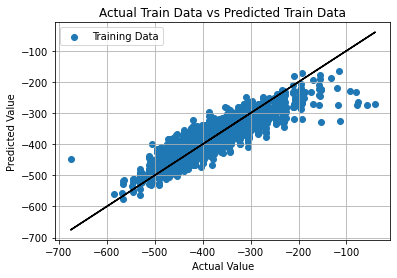

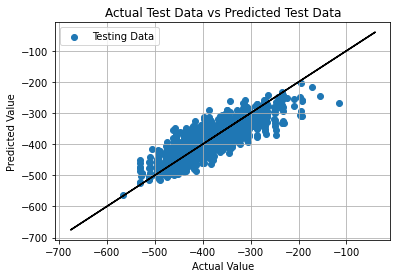

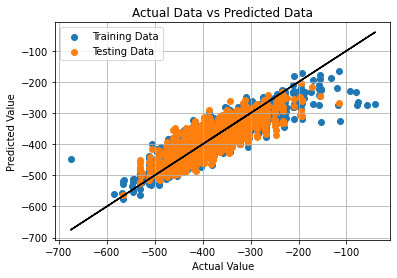

In [204]:
ytrain = y_train[:,1]
ytest = y_test[:,1]

plt.scatter(ytrain, y_pred_train,label='Training Data')
plt.title("Actual Train Data vs Predicted Train Data")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.plot(ytrain, ytrain, 'k-')
plt.grid()
plt.show()

plt.scatter(ytest, y_pred_test, label='Testing Data')
plt.title("Actual Test Data vs Predicted Test Data")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.plot(ytrain, ytrain, 'k-')
plt.grid()
plt.show()

plt.scatter(ytrain, y_pred_train,label='Training Data')
plt.scatter(ytest, y_pred_test, label='Testing Data')
plt.title("Actual Data vs Predicted Data")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.plot(ytrain, ytrain, 'k-')
plt.grid()
plt.show()

## Specific Heat 

In [162]:
n_cols = X_train.shape[1]

model = Sequential()
enc_1 = Dense(100, activation='relu', input_shape = (n_cols,))
model.add(enc_1)
model.add(Dropout(0.3))
enc_2 = Dense(42, activation='relu')
model.add(enc_2)
enc_3 = Dense(1, activation='relu')
model.add(enc_3)

lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error')

dnn_1 = model.fit(X_train, y_train[:,2].reshape((40296,1)), epochs=30, verbose=1, validation_split=0.1)

Epoch 1/30
1134/1134 [==============================] - 5s 3ms/step - loss: 46.2336 - val_loss: 7.5448
Epoch 2/30
1134/1134 [==============================] - 4s 3ms/step - loss: 10.1621 - val_loss: 5.7228
Epoch 3/30
1134/1134 [==============================] - 4s 3ms/step - loss: 8.5606 - val_loss: 4.5455
Epoch 4/30
1134/1134 [==============================] - 4s 3ms/step - loss: 7.5475 - val_loss: 4.2732
Epoch 5/30
1134/1134 [==============================] - 4s 3ms/step - loss: 6.6349 - val_loss: 3.9165
Epoch 6/30
1134/1134 [==============================] - 4s 3ms/step - loss: 5.7652 - val_loss: 3.7020
Epoch 7/30
1134/1134 [==============================] - 4s 4ms/step - loss: 5.0425 - val_loss: 3.8480
Epoch 8/30
1134/1134 [==============================] - 4s 4ms/step - loss: 4.4843 - val_loss: 3.5185
Epoch 9/30
1134/1134 [==============================] - 4s 4ms/step - loss: 4.0296 - val_loss: 3.3407
Epoch 10/30
1134/1134 [==============================] - 4s 4ms/step - loss: 3.6

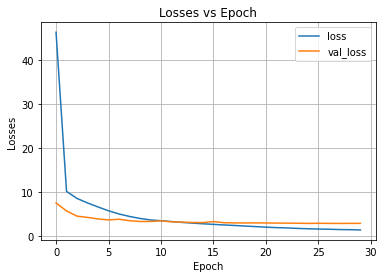

In [163]:
plt.plot(dnn_1.history['loss'], label='loss')
plt.plot(dnn_1.history['val_loss'], label='val_loss')
plt.title("Losses vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.grid()
plt.legend()
plt.show()

In [164]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

1260/1260 [==============================] - 2s 2ms/step


In [165]:
from sklearn.metrics import r2_score
print(r2_score(y_pred_train, y_train[:,2]))
print(r2_score(y_pred_test,y_test[:,2]))

0.9119541468312503
0.6557644656113509


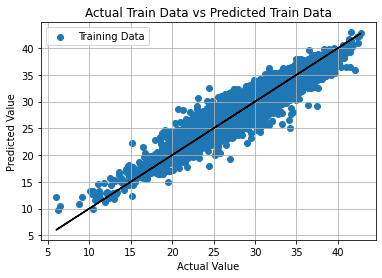

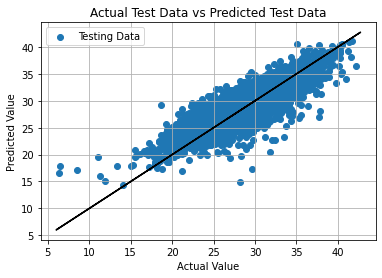

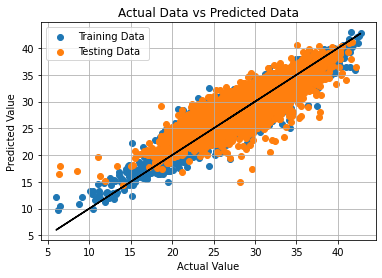

In [167]:
ytrain = y_train[:,2]
ytest = y_test[:,2]

plt.scatter(ytrain, y_pred_train,label='Training Data')
plt.title("Actual Train Data vs Predicted Train Data")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.plot(ytrain, ytrain, 'k-')
plt.grid()
plt.show()

plt.scatter(ytest, y_pred_test, label='Testing Data')
plt.title("Actual Test Data vs Predicted Test Data")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.plot(ytrain, ytrain, 'k-')
plt.grid()
plt.show()

plt.scatter(ytrain, y_pred_train,label='Training Data')
plt.scatter(ytest, y_pred_test, label='Testing Data')
plt.title("Actual Data vs Predicted Data")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.plot(ytrain, ytrain, 'k-')
plt.grid()
plt.show()